<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/EQNN_p4m_mnist_no-train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# p4m EQNN

In this notebook, we build the invariant Equivariant Quantum Neural Network under the p4m symmetry, consisting of the reflections over the X and Y axis, and the rotatations by 90 degrees.

We test the invariance of this model using the MNIST dataset and local transformations to perform reflections and rotations over the data.

The main reference is:

Approximately Equivariant Quantum Neural Network for $p4m$ Group Symmetries in Images. https://arxiv.org/abs/2310.02323.

# dataset

In [1]:
%%capture
pip install pennylane jax jaxlib

In [2]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import, division, print_function
import numpy as np
seed=12
np.random.seed(seed)
import sys, os, argparse
import tensorflow as tf
from tensorflow.python.framework import dtypes
# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
r"""
Load Classical image datasets.
Ising, MNIST, FashionMNIST, EMNIST, EuroSAT, Semeion dataset implemented.
"""

import os
import sys
import random
#sys.path.append(os.path.dirname(__file__))

from sklearn.utils import shuffle

import jax.numpy as jnp
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from typing import Tuple, List, Union

import pickle
from sklearn.model_selection import train_test_split

#from eurosat import EuroSAT, random_split
#from semeion import Semeion


import pickle, os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from urllib.request import urlopen


## ISING
def load_ising_data():

    # path to data directory (for testing)
    #path_to_data=os.path.expanduser('~')+'/Dropbox/MachineLearningReview/Datasets/isingMC/'

    url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

    ######### LOAD DATA
    # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
    data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
    # The labels are obtained from the following file:
    label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

    #DATA
    data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
    data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
    data=data.astype('int')
    data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

    #LABELS (convention is 1 for ordered states and 0 for disordered states)
    labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

    print("Finished loading data")
    return data, labels


#def load_ising_data(root: str, L:int)->Tuple[np.ndarray, np.ndarray]:
#    r"""Load the Ising model spin distribution stored in pickle file into
#    the numpy array. The pickle file contains the distribution of spins :math:`\{s_i\}_i` in
#    2 dimensional :math:`L \times L` lattice governed by the Hamiltonian :

#    ..math:

#        H = -\sum_{\langle i, j \rangle} J s_i s_j.

#    Args:
#        root (str): Root directory where the pickle files for data ``Ising2D_L{L}_T=All.pkl`` and
#            for labels ``Ising2D_L{L}_T=All_labels.pkl`` are located.
#        L (int): Lattice dimension for 2D Ising model.
#    """
#    path = os.path.join(root, "L" + str(L))
#    data_path = os.path.join(path, "Ising2D_L" + str(L) + "_T=All.pkl")
#    label_path = os.path.join(path, "Ising2D_L" + str(L) + "_T=All_labels.pkl")

#    data = pickle.load(open(data_path, "rb"))
#    labels = pickle.load(open(label_path, "rb"))

#    return data, labels


def prepare_ising_data(
    data: np.array,
    labels: np.array,
    test_size: float = 0.2,
    validation_size=5000,
) -> Tuple[np.ndarray, ...]:
    r"""Function to prepare 2D Ising model data in such way that it is trainable with neural
    newtork. Code originally taken from `Notebook 12: Identifying Phases in the 2D Ising
    Model with TensorFlow <http://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB12_CIX-DNN_ising_TFlow.html>`__

    Args:
        data (np.array): Numpy array of Ising spin distribution loaded from ``Ising2D_L{L}_T=All.pkl``
        labels (np.array): Numpy array of Ising spin distribution loaded from ``Ising2D_L{L}_T=All.pkl``
        test_size (float, optional): The ratio of the test set within the whole dataset. Defaults to 0.2.

    Returns:
        Tuple[np.ndarray, ...]: Tuple of training and test data/labels.
    """
    # divide data into ordered, critical and disordered
    X_ordered = data[:7000, :]
    Y_ordered = labels[:7000]

    # X_critical = data[70000:100000, :]
    # Y_critical = labels[70000:100000]

    X_disordered = data[10000:15000, :]
    Y_disordered = labels[10000:15000]

    # Define training and test data sets. Use only ordered and disordered
    # phases for binary classification.
    X = np.concatenate((X_ordered, X_disordered)).astype(
        np.float32
    )
    Y = np.concatenate(
        (Y_ordered, Y_disordered)
    )

    # Randomly spilt the ordered and disordered states into the training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        np.array(X), np.array(Y), test_size=test_size, train_size=1.0 - test_size
    )

    if not 0 <= validation_size <= len(X_train):
        raise ValueError(
            "Validation size should be between 0 and {}. Received: {}.".format(
                len(X_train), validation_size
            )
        )

    validation_size = 5000
    # X_validation = X_train[:validation_size]
    # Y_validation = Y_train[:validation_size]
    X_train = X_train[validation_size:]
    Y_train = Y_train[validation_size:]


    #X_train, Y_train = shuffle(X_train, Y_train, random=random.random)
    #X_test, Y_test = shuffle(X_test, Y_test, random=random.random)
    X_train, Y_train = shuffle(X_train, Y_train)
    X_test, Y_test = shuffle(X_test, Y_test)

    return X_train, Y_train, X_test, Y_test


In [4]:
data_ising, labels_ising = load_ising_data()
X_train, Y_train, X_test, Y_test = prepare_ising_data(data_ising, labels_ising)

Finished loading data


### MNIST

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

# Function to reduce the size of the images
num_training = 200
num_test = 100

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filter the training data to include only digits 0, 1, and 8
train_filter = np.isin(y_train, [0, 1])
X_train = X_train[train_filter]
y_train = y_train[train_filter]

# Filter the test data to include only digits 0, 1, and 8
test_filter = np.isin(y_test, [0, 1])
X_test = X_test[test_filter]
y_test = y_test[test_filter]

# Normalize the training and test data and reduce the size
X_train = X_train[:num_training] / 255.0
y_train = y_train[:num_training]
X_test = X_test[:num_test] / 255.0
y_test = y_test[:num_test]


In [6]:
from pennylane import numpy as np
from tensorflow.keras.datasets import mnist
from scipy.ndimage import zoom

# Function to resize images
def resize_images(images, new_size=(16, 16)):
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1]))
    for i in range(images.shape[0]):
        resized_images[i] = zoom(images[i], (new_size[0] / images.shape[1], new_size[1] / images.shape[2]))
    return resized_images

num_training = 200
num_test = 100

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filter the training data to include only digits 0 and 1
train_filter = np.isin(y_train, [0, 1])
X_train = X_train[train_filter]
y_train = y_train[train_filter]

# Filter the test data to include only digits 0 and 1
test_filter = np.isin(y_test, [0, 1])
X_test = X_test[test_filter]
y_test = y_test[test_filter]

# Normalize the images
X_train = X_train[:num_training] / 255.0
y_train = y_train[:num_training]
X_test = X_test[:num_test] / 255.0
y_test = y_test[:num_test]

# Resize the images
X_train = resize_images(X_train)
X_test = resize_images(X_test)

# Add a channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]



# model

In [7]:
import pennylane as qml
from typing import List
import jax.numpy as jnp

# Function to embed an image into a quantum state
def embed_image(img: jnp.ndarray, wires: List[int]) -> None:
    n = len(wires) // 2

    # If the image is single-channel, reshape it to 2D
    if img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])

    # Initialize the feature vector with zeros
    features = jnp.zeros(2 ** (2 * n))

    # Fill the feature vector with sine-transformed pixel values
    for i in range(2**n):
        for j in range(2**n):
            features = features.at[2**n * i + j].set(
                jnp.sin(jnp.pi / 2 * (2 * img[i, j] - 1))
            )

    # Normalize the feature vector
    features = features / jnp.sqrt(jnp.sum(features**2))

    # Use amplitude embedding to encode the feature vector into quantum state
    qml.AmplitudeEmbedding(features, wires=wires)

# Function to apply a U2 gate to a pair of qubits
def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])  # Apply RX rotation to the first qubit
    qml.RX(phi[1], wires=wires[1])  # Apply RX rotation to the second qubit
    qml.IsingZZ(phi[2], wires=wires)  # Apply Ising ZZ interaction
    qml.RX(phi[3], wires=wires[0])  # Apply another RX rotation to the first qubit
    qml.RX(phi[4], wires=wires[1])  # Apply another RX rotation to the second qubit
    qml.IsingYY(phi[5], wires=wires)  # Apply Ising YY interaction

# Function to apply a U4 gate to four qubits
def U4(phi, wires):
    qml.RX(phi[0], wires=wires[0])  # Apply RX rotation to the first qubit
    qml.RX(phi[1], wires=wires[1])  # Apply RX rotation to the second qubit
    qml.RX(phi[0], wires=wires[2])  # Apply RX rotation to the third qubit
    qml.RX(phi[1], wires=wires[3])  # Apply RX rotation to the fourth qubit

    # Define the Z matrix
    Z = jnp.array([[1, 0], [0, -1]])

    # Create a Kronecker product of Z matrices for four qubits
    Z4 = jnp.kron(Z, jnp.kron(Z, jnp.kron(Z, Z)))

    # Create a diagonal matrix with phase shifts
    Z4_diag = jnp.diag(jnp.exp(1j * phi[2] * Z4))

    # Apply a diagonal unitary matrix to the four qubits
    qml.DiagonalQubitUnitary(Z4_diag, wires=wires)

# Function to apply a pooling ansatz to a pair of qubits
def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])  # Apply RX rotation to the first qubit
    qml.RX(phi[1], wires=wires[1])  # Apply RX rotation to the second qubit
    qml.RY(phi[2], wires=wires[1])  # Apply RY rotation to the second qubit
    qml.RZ(phi[3], wires=wires[1])  # Apply RZ rotation to the second qubit
    qml.CRX(phi[4], wires=[wires[1], wires[0]])  # Apply controlled RX gate with second qubit as control


In [8]:
import pennylane as qml

# Function to define the full QCNN (Quantum Convolutional Neural Network) circuit
def qcnn_full(params, wires, trans_inv=True):
    if trans_inv:  # 14 params
        # Apply U2 gates in a translationally invariant manner
        for i in range(int(len(wires) / 2)):
            U2(params[:6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[:6], [wires[1], wires[2]])
        U2(params[:6], [wires[5], wires[6]])
        U2(params[:6], [wires[0], wires[3]])
        U2(params[:6], [wires[4], wires[7]])

        # Insert a barrier to separate different parts of the circuit
        qml.Barrier()

        # Apply U4 gates
        U4(params[6:9], wires[0:4])
        U4(params[6:9], wires[4:8])
        U4(params[6:9], wires[2:6])
        U4(params[6:9], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[9:14], [wires[2 * i], wires[2 * i + 1]])

        # Final barrier
        qml.Barrier()

    else:  # 93 params
        # Apply U2 gates without translational invariance
        for i in range(int(len(wires) / 2)):
            U2(params[4 * i:i * 4 + 6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[24:30], [wires[1], wires[2]])
        U2(params[30:36], [wires[5], wires[6]])
        U2(params[36:42], [wires[0], wires[3]])
        U2(params[42:48], [wires[4], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply U4 gates
        U4(params[48:51], wires[0:4])
        U4(params[51:54], wires[4:8])
        U4(params[54:57], wires[2:6])
        U4(params[57:60], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[60 + i * 5:60 + i * 5 + 5], [wires[2 * i], wires[2 * i + 1]])

        # Insert a barrier
        qml.Barrier()

        # Apply another U4 gate and pooling ansatz
        U4(params[80:83], [wires[1], wires[3], wires[5], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply final pooling ansatz
        Pooling_ansatz(params[83:88], [wires[1], wires[3]])
        Pooling_ansatz(params[88:93], [wires[5], wires[7]])



# p4m EQNN


In this model, we work with a p4m equivariant quantum neural network whose output has been shown to be invariant under a reflection along the Y-axis. The model operates with 16x16 pixel images.

This version consists of U2 and U4 gates, which are applied with the same parameters to each pair or quartet of qubits, respectively. This ensures invariance under translations.

One detail is that this model consists of 4 measurements.







### 4 measurements

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


 Output with Probabilities for Original Image: (Array([0.31233212, 0.2349403 , 0.2575215 , 0.19520642], dtype=float32), Array([0.31526363, 0.20953313, 0.22877286, 0.24643065], dtype=float32))
 Output with Probabilities for Image Reflected over Y-axis: (Array([0.3123321 , 0.23494028, 0.25752145, 0.19520646], dtype=float32), Array([0.31526363, 0.20953308, 0.22877291, 0.2464307 ], dtype=float32))


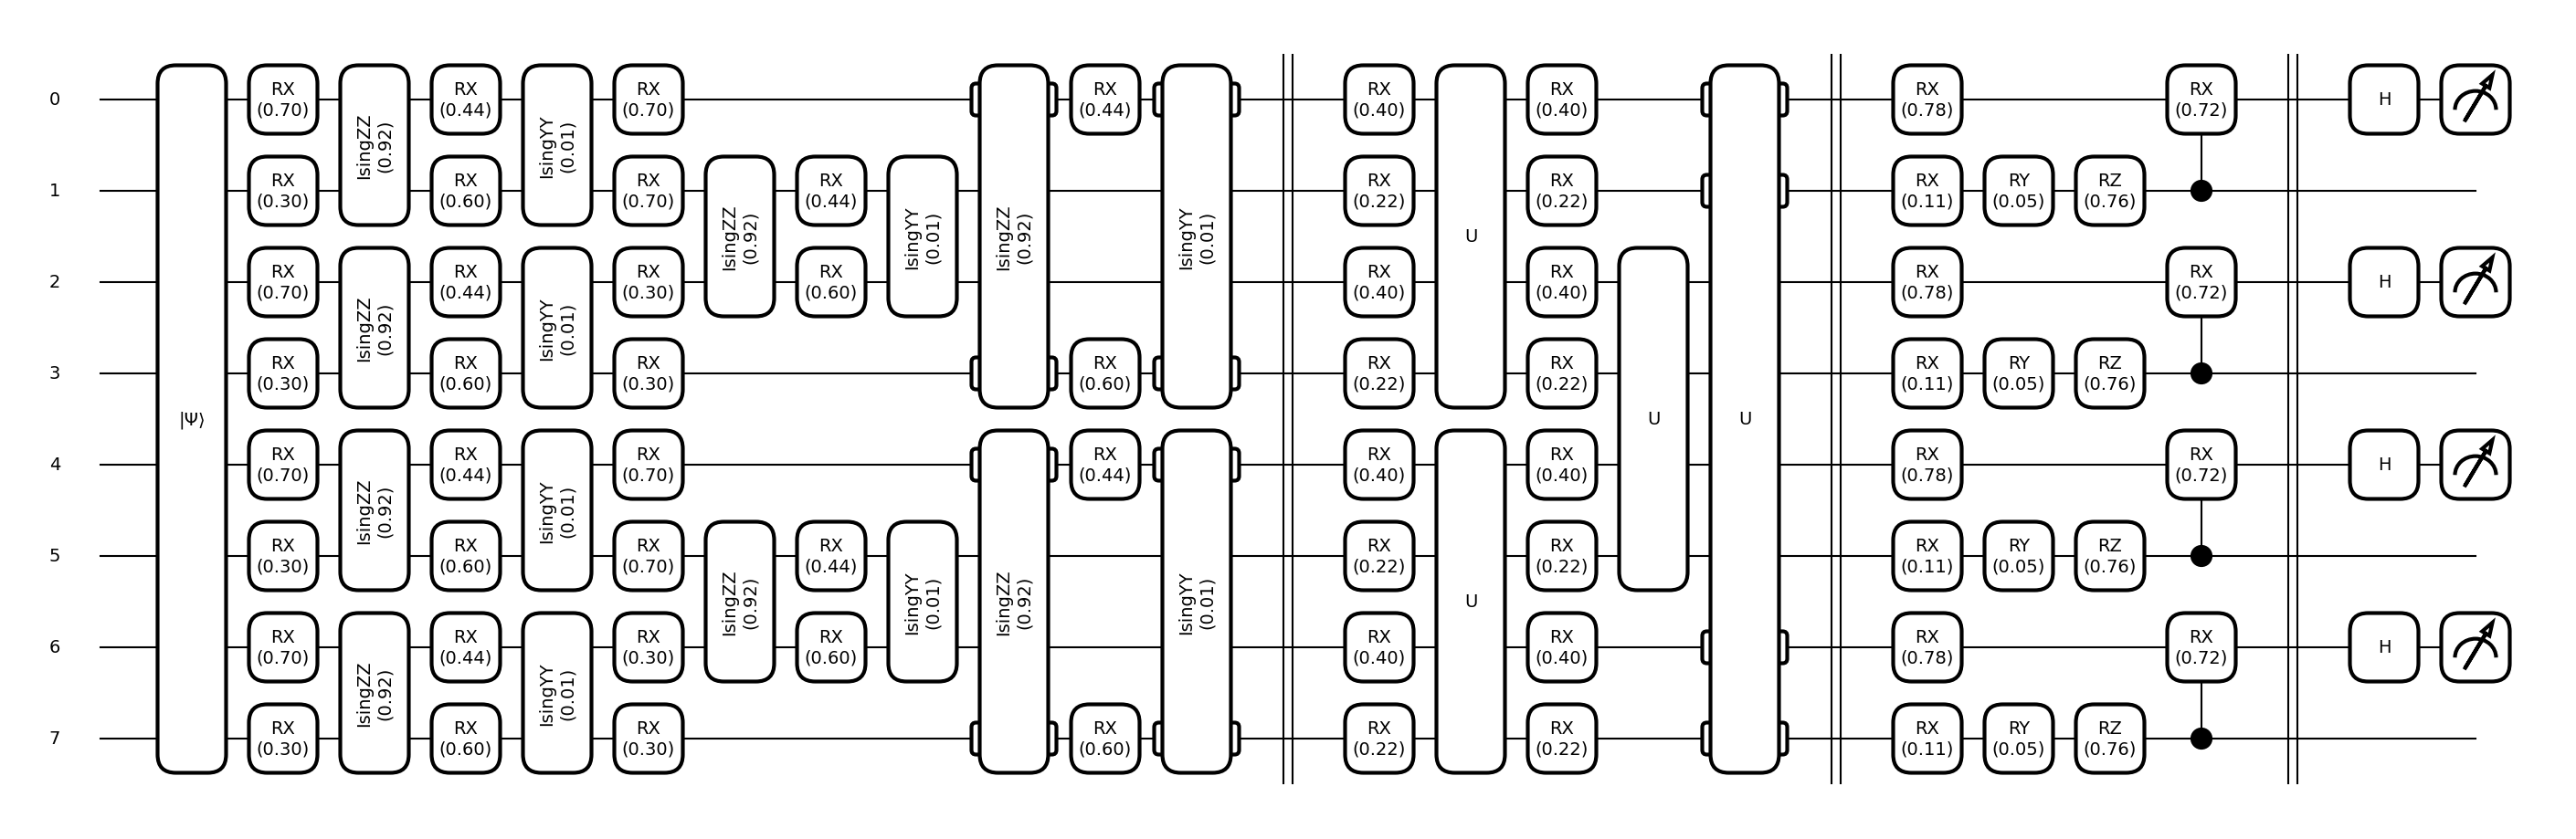

In [9]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List


params = jnp.array(np.random.random(93))
matrix = jnp.array(X_train[0])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)

@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier(X, params, trans_inv = True):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7], trans_inv)
    qml.Hadamard(0)
    qml.Hadamard(2)
    qml.Hadamard(4)
    qml.Hadamard(6)
    return qml.probs(wires = [0,2]), qml.probs(wires = [4,6])

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        qml.Hadamard(0)
        qml.Hadamard(2)
        qml.Hadamard(4)
        qml.Hadamard(6)
        return qml.probs(wires = [0,2]), qml.probs(wires = [4,6])

    return qml.draw_mpl(temp_circuit, decimals = 2)()

# Draw the circuit
draw_circuit(matrix, params)

# execute the circuit for both cases: original image and reflected image
result1 = EQNN_classifier(matrix, params)
result2 = EQNN_classifier(matrix_reflected, params)

print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")


In [10]:
matrix = jnp.array(X_train[0])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_classifier(matrix, params)
result2 = EQNN_classifier(matrix_reflected_y_jax, params)
result3 = EQNN_classifier(matrix_reflected_x_jax, params)
result4 = EQNN_classifier(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

 Output with Probabilities for Original Image: (Array([0.31233212, 0.2349403 , 0.2575215 , 0.19520642], dtype=float32), Array([0.31526363, 0.20953313, 0.22877286, 0.24643065], dtype=float32))
 Output with Probabilities for Image Reflected over Y-axis: (Array([0.3123321 , 0.23494028, 0.25752145, 0.19520646], dtype=float32), Array([0.31526363, 0.20953308, 0.22877291, 0.2464307 ], dtype=float32))
 Output with Probabilities for Image Reflected over X-axis: (Array([0.31233212, 0.2349403 , 0.25752145, 0.19520645], dtype=float32), Array([0.31526366, 0.20953313, 0.22877286, 0.24643071], dtype=float32))
 Output with Probabilities for Image Rotated 90 Degrees: (Array([0.31526363, 0.20953308, 0.22877282, 0.2464307 ], dtype=float32), Array([0.312332  , 0.23494026, 0.25752145, 0.19520643], dtype=float32))


### Changing the directions of the CNOT gates

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


 Output with Probabilities for Original Image: (Array([0.48504308, 0.51495737], dtype=float32), Array([0.48007858, 0.51992184], dtype=float32))
 Output with Probabilities for Image Reflected over Y-axis: (Array([0.48398167, 0.5160188 ], dtype=float32), Array([0.56026465, 0.43973583], dtype=float32))


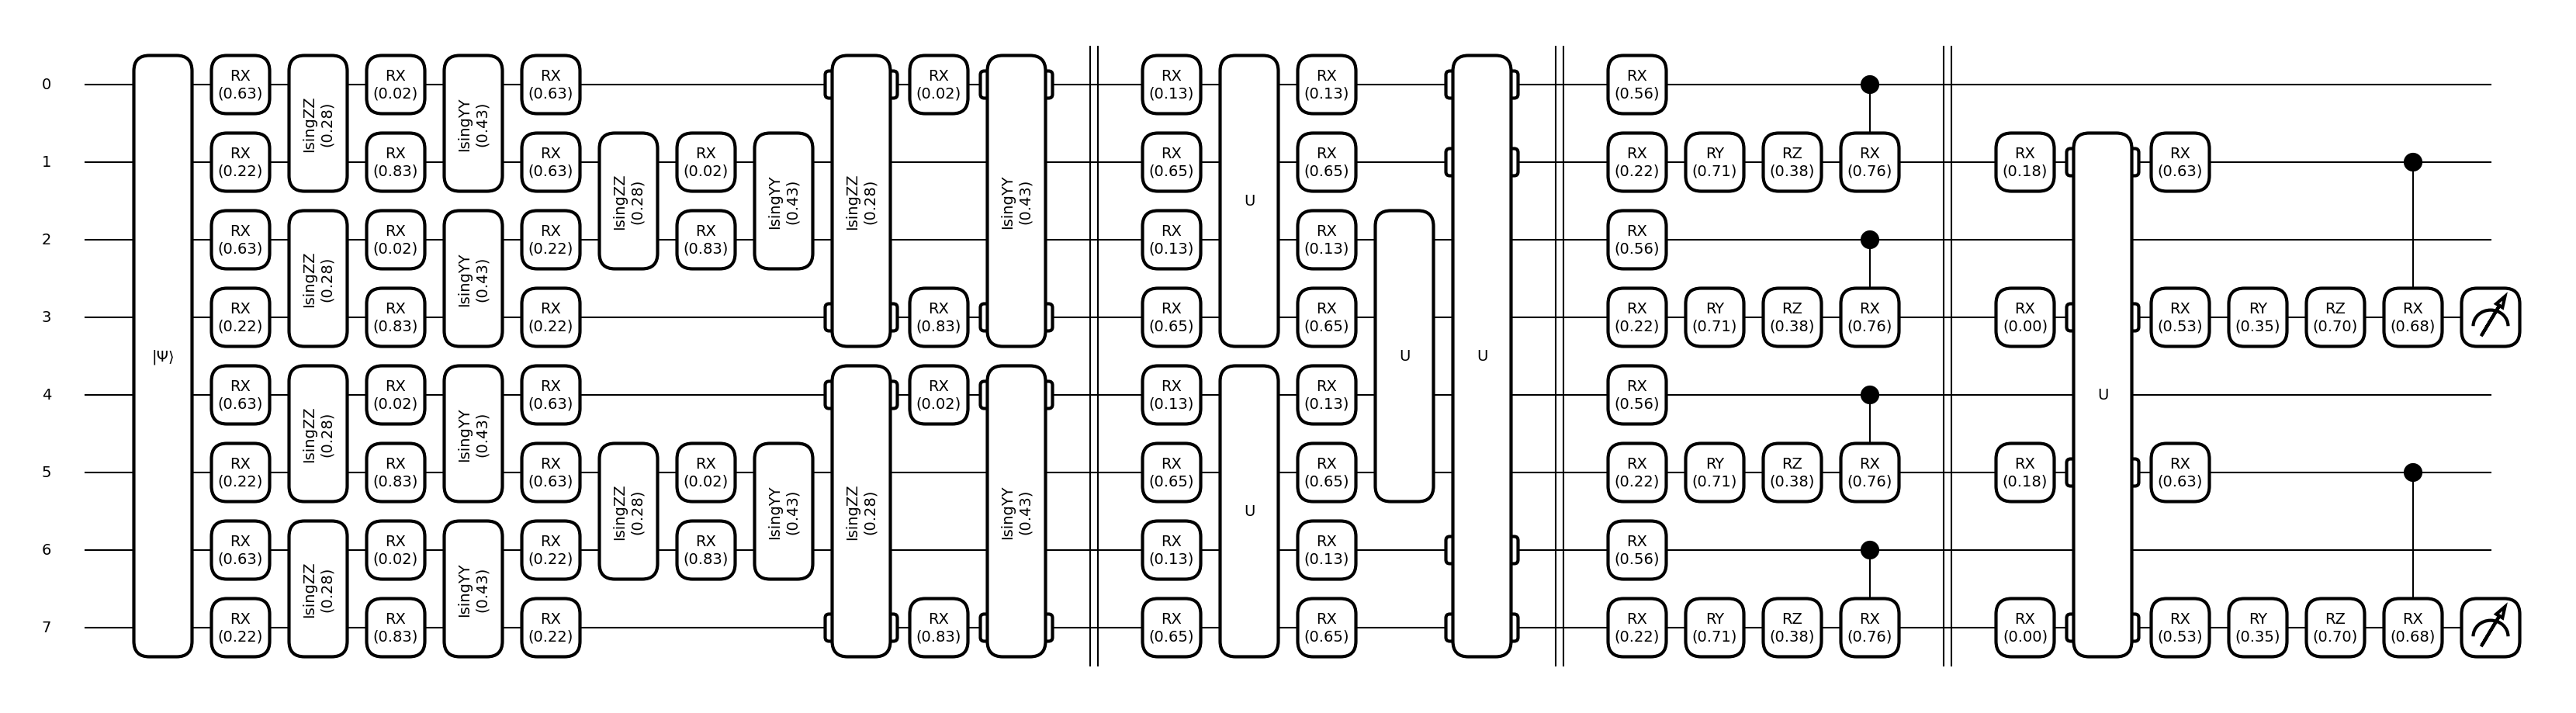

In [11]:

def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[0], wires[1]])


params = jnp.array(np.random.random(93))
matrix = jnp.array(X_train[0])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)

@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier(X, params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7])
    U4(params[14:17], wires = [1,3,5,7])
    Pooling_ansatz(params[17:22], [1,3])
    Pooling_ansatz(params[17:22], [5,7])
    return qml.probs(wires = [3]), qml.probs(wires = [7])

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        U4(params[14:17], wires = [1,3,5,7])
        Pooling_ansatz(params[17:22], [1,3])
        Pooling_ansatz(params[17:22], [5,7])
        return qml.probs(wires = [3]), qml.probs(wires = [7])

    return qml.draw_mpl(temp_circuit, decimals = 2)()

# Draw the circuit
draw_circuit(matrix, params)

# execute the circuit for both cases: original image and reflected image
result1 = EQNN_classifier(matrix, params)
result2 = EQNN_classifier(matrix_reflected, params)

print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")

## 2 measurements

The EQNN with only two measurements has shown that is invariant under the reflexion symmetry over the data. Nevertheless, It presents a slight difference if we apply a rotated by 90 degrees operation over the data.

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


 Output con Probabilidades para imagen original: (Array([0.49506688, 0.5049332 ], dtype=float32), Array([0.4930955, 0.5069045], dtype=float32))
 Output con Probabilidades para imagen reflejada:  (Array([0.47277302, 0.52722704], dtype=float32), Array([0.49723947, 0.50276065], dtype=float32))


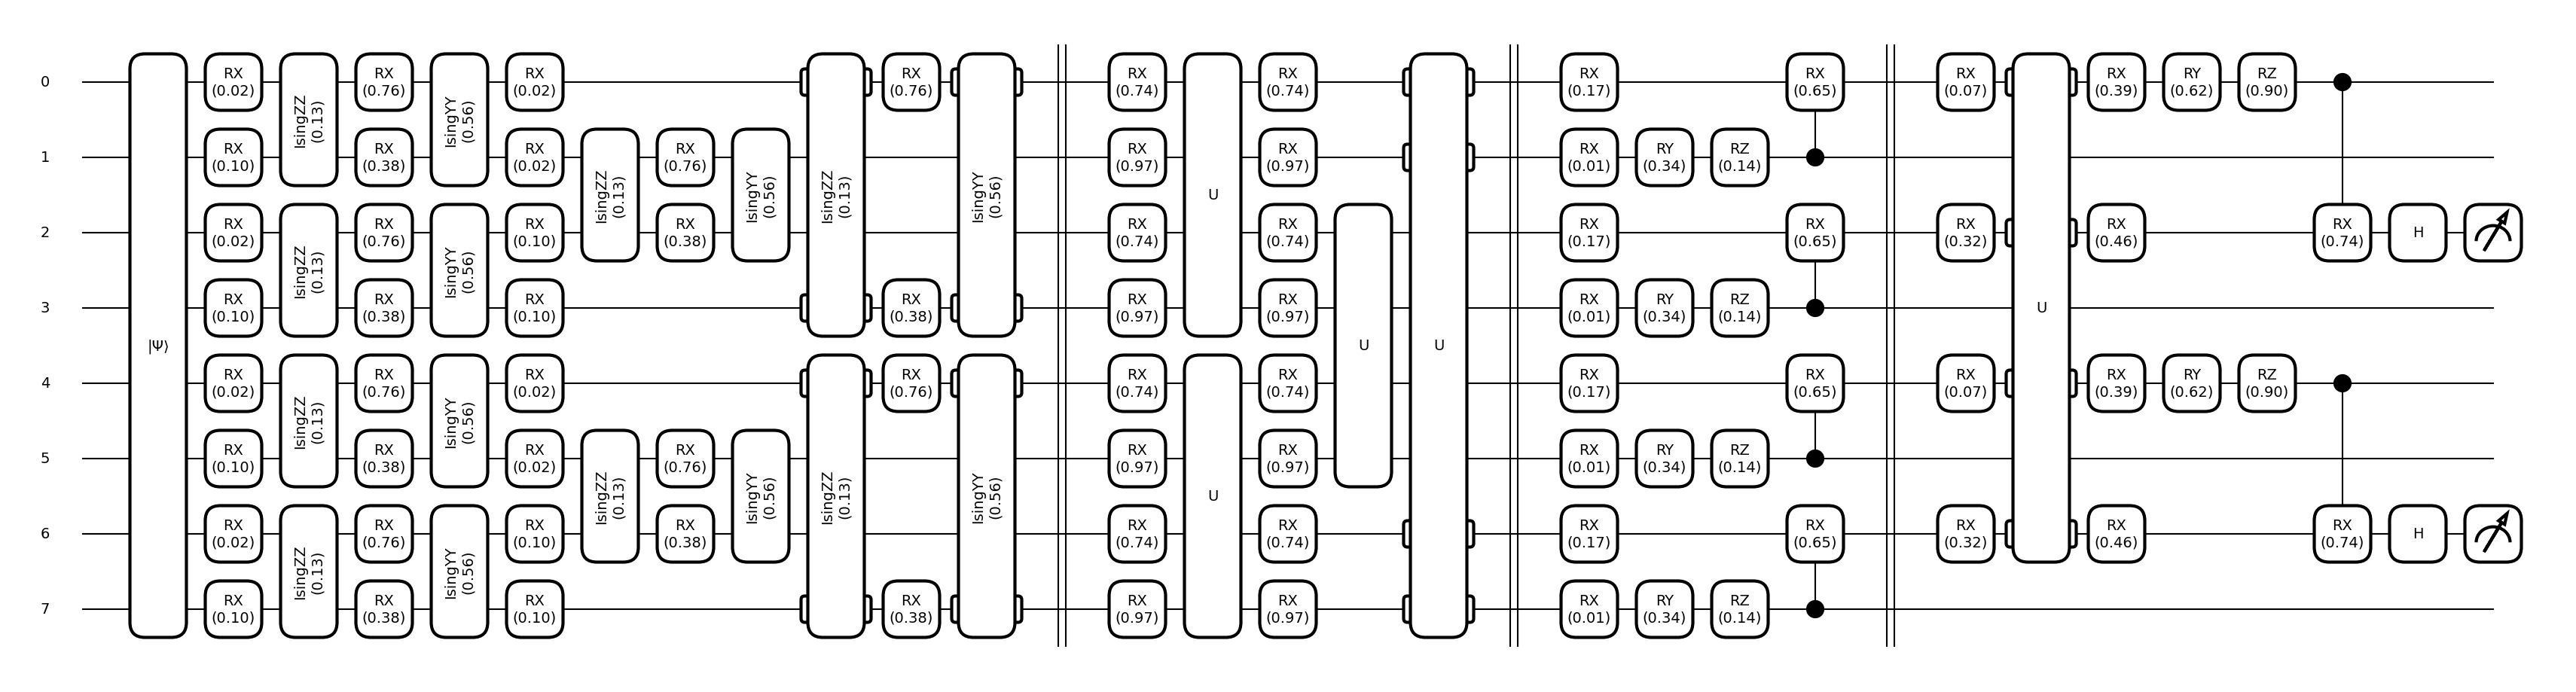

In [12]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List


def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])


params = jnp.array(np.random.random(93))
matrix = jnp.array(X_train[1])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)

@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier_2m(X, params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7])
    U4(params[14:17], wires = [0,2,4,6])
    Pooling_ansatz(params[17:22], [2,0])
    Pooling_ansatz(params[17:22], [6,4])
    qml.Hadamard(2)
    qml.Hadamard(6)
    #return qml.probs(wires = meas_wires[:len(meas_wires)//2]), qml.probs(wires = meas_wires[len(meas_wires)//2:])
    #return qml.probs(wires = [3,7])
    return qml.probs(wires = [2]), qml.probs(wires = [6])
    #return qml.probs(wires = [3,7])


## parte para imprimir el circuito. Simplemente se convierte en numpy arrays la matriz y los parametros
def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        U4(params_np[14:17], wires = [0,2,4,6])
        Pooling_ansatz(params_np[17:22], [2,0])
        Pooling_ansatz(params_np[17:22], [6,4])
        qml.Hadamard(2)
        qml.Hadamard(6)
        #return qml.probs(wires = [3,7])#, qml.probs(wires = meas_wires[len(meas_wires)//2:])
        return qml.probs(wires = [2]), qml.probs(wires = [6])

    return qml.draw_mpl(temp_circuit, decimals = 2)()

# Dibujar el circuito
draw_circuit(matrix, params)

# Ejecutar el circuito
result1 = EQNN_classifier_2m(matrix, params)
result2 = EQNN_classifier_2m(matrix_reflected, params)

print(f" Output con Probabilidades para imagen original: {result1}")
print(f" Output con Probabilidades para imagen reflejada:  {result2}")

In [13]:
matrix = jnp.array(X_train[0])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_classifier_2m(matrix, params)
result2 = EQNN_classifier_2m(matrix_reflected_y_jax, params)
result3 = EQNN_classifier_2m(matrix_reflected_x_jax, params)
result4 = EQNN_classifier_2m(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

 Output with Probabilities for Original Image: (Array([0.50378656, 0.49621344], dtype=float32), Array([0.5115778, 0.4884222], dtype=float32))
 Output with Probabilities for Image Reflected over Y-axis: (Array([0.53753406, 0.46246618], dtype=float32), Array([0.50447726, 0.4955228 ], dtype=float32))
 Output with Probabilities for Image Reflected over X-axis: (Array([0.503669, 0.496331], dtype=float32), Array([0.5358005 , 0.46419942], dtype=float32))
 Output with Probabilities for Image Rotated 90 Degrees: (Array([0.50447726, 0.49552265], dtype=float32), Array([0.537534  , 0.46246594], dtype=float32))


## original

The original quantum classifier is the less invariant model of these models. It presents differences among the original image, the reflected images, and the rotated image. So, it's hard to say that is invariant under these operations.

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option 

 Output con Probabilidades para imagen original: (Array([0.59102994, 0.40896958], dtype=float32), Array([0.581721  , 0.41827866], dtype=float32))
 Output con Probabilidades para imagen reflejada:  (Array([0.55707437, 0.4429253 ], dtype=float32), Array([0.5684154, 0.4315842], dtype=float32))


(<Figure size 4300x900 with 1 Axes>, <Axes: >)

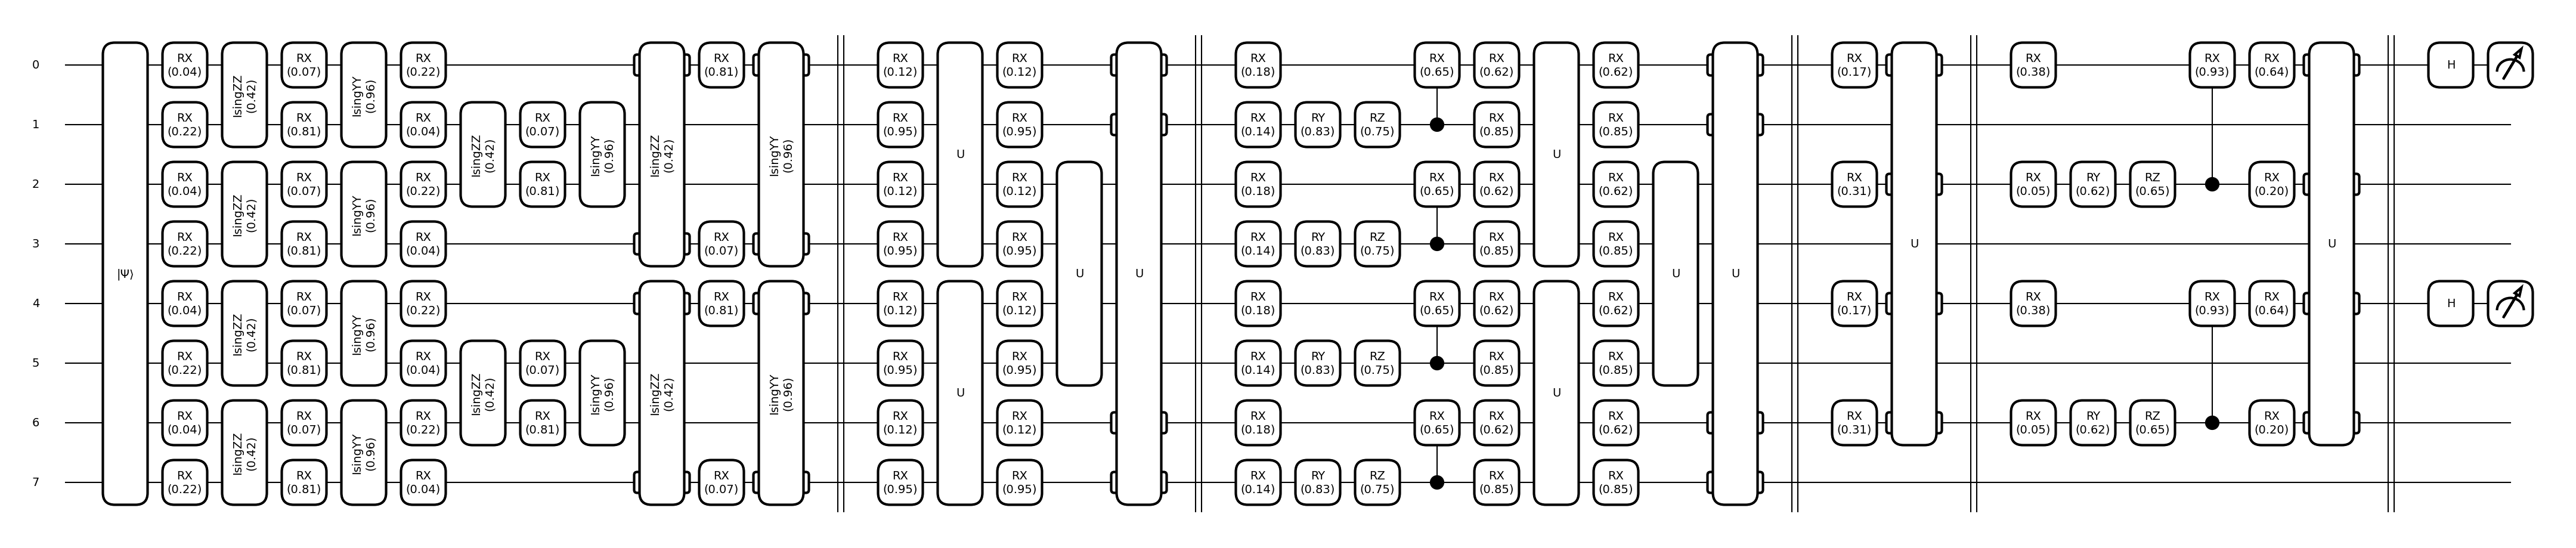

In [14]:
import json
import jax.numpy as jnp
import numpy as np
import pennylane as qml
from math import ceil

# Configuración inicial

class EquivQCNN:
    def __init__(self, num_qubits, num_measured, trans_inv, **kwargs):
        qnn_architecture = {
            'U2_conv_filters': [U2],
            'U4_conv_filters': [U4],
            'pooling': Pooling_ansatz,
            'alternating': False
        }

        self._sym_break = kwargs.get('sym_break', False)
        self._qnn_architecture = qnn_architecture
        self._num_qubits = num_qubits
        self._num_measured = num_measured
        self._trans_inv = trans_inv

        self._U2_conv_filters = qnn_architecture['U2_conv_filters']
        self._U4_conv_filters = qnn_architecture['U4_conv_filters']
        self._pooling = qnn_architecture['pooling']
        self._alternating = qnn_architecture['alternating']

        depth = ceil(np.log2(num_qubits // num_measured))

        self._meas_wires = [i for i in range(num_qubits // 2)]
        while len(self._meas_wires) > num_measured // 2:
            self._meas_wires = [self._meas_wires[i] for i in range(0, len(self._meas_wires), 2)]

        self._meas_wires.extend([q + num_qubits // 2 for q in self._meas_wires])
        self._meas_wires = np.array(self._meas_wires)

        num_gates = 1
        if not trans_inv:
            num_gates = num_qubits // 2

        if not self._alternating:
            self._num_params = num_gates * (sum([6 for _ in self._U2_conv_filters]) +
                                            depth * (sum([3 for _ in self._U4_conv_filters]) +
                                                     5))
        else:
            self._num_params = num_gates * depth * (sum([6 for _ in self._U2_conv_filters]) +
                                                    sum([3 for _ in self._U4_conv_filters]) +
                                                    5)

        if self._sym_break:
            self._num_params += 1

    def _U2_conv(self, params, gate, wires):
        idx = 0
        for i in range(0, len(wires), 2):
            gate(params[idx], wires=[wires[i], wires[i + 1]])
            idx += 1

        for i in range(1, len(wires) - 1, 2):
            gate(params[idx], wires=[wires[i], wires[i + 1]])
            idx += 1

        gate(params[idx], wires=[wires[-1], wires[0]])

    def _U4_conv(self, params, gate, wires):
        idx = 0
        for i in range(0, len(wires), 4):
            gate(params[idx], wires=[wires[i + j] for j in range(4)])
            idx += 1

        for i in range(2, len(wires) - 2, 4):
            gate(params[idx], wires=[wires[i + j] for j in range(4)])
            idx += 1

        if len(wires) > 4:
            gate(params[idx], wires=[wires[0], wires[1], wires[-2], wires[-1]])

    def _get_circuit(self, num_qubits, num_measured, U2_conv_filters, U4_conv_filters, pooling, alternating, trans_inv, sym_break):
        def circuit(params):
            idx = 0
            wires = np.array([i for i in range(num_qubits)])

            if not alternating:
              ### U2
                for gate in U2_conv_filters:
                    num_gates = len(wires) // 2
                    if trans_inv:
                        conv_params = jnp.repeat(jnp.array([params[idx: idx + 6]]), num_gates, axis=0)
                        num_gates = 1
                    else:
                        conv_params = params[idx: idx + num_gates * 6].reshape((num_gates, 6))

                    self._U2_conv(conv_params, gate, wires[:len(wires) // 2])
                    self._U2_conv(conv_params, gate, wires[len(wires) // 2:])
                    idx += num_gates * 6
                    qml.Barrier()

            ### U4
            while len(wires) > num_measured:
                if alternating:
                    for gate in U2_conv_filters:
                        num_gates = len(wires) // 2
                        if trans_inv:
                            conv_params = jnp.repeat(jnp.array([params[idx: idx + 6]]), num_gates, axis=0)
                            num_gates = 1

                        else:
                            conv_params = params[idx: idx + num_gates * 6].reshape((num_gates, 6))

                        self._U2_conv(conv_params, gate, wires[:len(wires) // 2])
                        self._U2_conv(conv_params, gate, wires[len(wires) // 2:])
                        idx += num_gates * 6
                        qml.Barrier()
                for gate in U4_conv_filters:
                    num_gates = len(wires) // 2
                    if trans_inv:
                        conv_params = jnp.repeat(jnp.array([params[idx: idx + 3]]), num_gates, axis=0)
                        num_gates = 1
                    else:
                        conv_params = params[idx: idx + num_gates * 3].reshape((num_gates, 3))

                    self._U4_conv(conv_params, gate, wires)
                    idx += num_gates * 3
                    qml.Barrier()
                conv_params = jnp.repeat(jnp.array([params[idx: idx + 5]]), len(wires) // 4, axis=0)
                idx += 5

                traced_out_wires = []
                for i in range(0, len(wires) // 2 - 1, 2):
                    pooling(conv_params[i // 2], wires=[wires[i], wires[i + 1]])
                    traced_out_wires.append(i + 1)

                for i in range(len(wires) // 2, len(wires) - 1, 2):
                    pooling(conv_params[(i - len(wires) // 2) // 2], wires=[wires[i], wires[i + 1]])
                    traced_out_wires.append(i + 1)


                for gate in U4_conv_filters:
                    num_gates = len(wires) // 2
                    if trans_inv:
                        conv_params = jnp.repeat(jnp.array([params[idx: idx + 3]]), num_gates, axis=0)
                        num_gates = 1
                    else:
                        conv_params = params[idx: idx + num_gates * 3].reshape((num_gates, 3))

                    self._U4_conv(conv_params, gate, wires)
                    idx += num_gates * 3
                    qml.Barrier()
                conv_params = jnp.repeat(jnp.array([params[idx: idx + 5]]), len(wires) // 4, axis=0)
                idx += 5

                wires = np.delete(wires, traced_out_wires)



            if sym_break:
                for i in wires:
                    qml.RZ(params[-1], wires=i)

        return circuit

    def get_circuit(self):
        return self._get_circuit(self._num_qubits, self._num_measured, self._U2_conv_filters, self._U4_conv_filters,
                                 self._pooling, self._alternating, self._trans_inv, self._sym_break), self._meas_wires

# Configuración del dispositivo y parámetros

params = jnp.array(np.random.random(93))
matrix = jnp.array(X_train[0])
matrix_reflected = np.fliplr(matrix)


num_qubits = 8
num_measured = 2
trans_inv = True
params = np.random.random(64)

model = EquivQCNN(num_qubits, num_measured, trans_inv)
circuit, meas_wires = model.get_circuit()

# Definir el QNode
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def EQNN_original(X,params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    circuit(params)
    for i in meas_wires:
        qml.Hadamard(i)
    return qml.probs(wires = meas_wires[:len(meas_wires)//2]), qml.probs(wires = meas_wires[len(meas_wires)//2:])

# Ejecutar el circuito

result1 = EQNN_original(matrix, params)
result2 = EQNN_original(matrix_reflected, params)

print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")

qml.draw_mpl(EQNN_original, decimals = 2)( matrix, params)

In [15]:
matrix = jnp.array(X_train[0])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_original(matrix, params)
result2 = EQNN_original(matrix_reflected_y_jax, params)
result3 = EQNN_original(matrix_reflected_x_jax, params)
result4 = EQNN_original(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


 Output with Probabilities for Original Image: (Array([0.59102994, 0.40896958], dtype=float32), Array([0.581721  , 0.41827866], dtype=float32))
 Output with Probabilities for Image Reflected over Y-axis: (Array([0.55707437, 0.4429253 ], dtype=float32), Array([0.56841534, 0.43158418], dtype=float32))
 Output with Probabilities for Image Reflected over X-axis: (Array([0.55705327, 0.44294637], dtype=float32), Array([0.57388276, 0.42611673], dtype=float32))
 Output with Probabilities for Image Rotated 90 Degrees: (Array([0.56841564, 0.43158418], dtype=float32), Array([0.55707455, 0.44292524], dtype=float32))
